# Homework 2: Multiclass Classification with PyTorch

In this assignment, you will build, train, and evaluate a neural network for multiclass classification using PyTorch.
You will use the [Garbage dataset](https://www.kaggle.com/datasets/mostafaabla/garbage-classification).
The goal is to gain hands-on experience with:
- Dataset preparation 
- Building two  PyTorch models
- Loss functions for multiclass
- Training loop and evaluation
- Visualize of performance

## About Dataset
### Context
This dataset has 15,150 images from 12 different classes of household garbage; paper, cardboard, biological, metal, plastic, green-glass, brown-glass, white-glass, clothes, shoes, batteries, and trash.

Garbage Recycling is a key aspect of preserving our environment. To make the recycling process possible/easier, the garbage must be sorted to groups that have similar recycling process. I found that most available data sets classify garbage into a few classes (2 to 6 classes at most). Having the ability to sort the household garbage into more classes can result in dramatically increasing the percentage of the recycled garbage.

### Content
An ideal setting for data collection would be to place a camera above a conveyor where the garbage comes one by one, so that the camera can capture real garbage images. But since such a setup is not feasible at the moment I collected most of the images in this dataset by web scraping, I tried to get images close to garbage images whenever possible, for example in biological garbage category I searched for rotten vegetables, rotten fruits and food remains, etc. However, for some classes such as clothes or shoes it was more difficult to get images of clothes or shoes from the garbage, so mostly it was images of normal clothes. Nevertheless, being able to classify the images of this data set to 12 classes can be a big step towards improving the recycling process.

### Imports

In [122]:
import torch
import torchvision
import torch.nn as nn
import kagglehub
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import os
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms


torch.manual_seed(42)


### Dwonload and prepare dataset from kagglehub
`kagglehub.dataset_download` downloads and extracts Kaggle datasets to a local cache directory (usually under `~/.cache/kagglehub/datasets/`). It returns the path to the unzipped dataset, preserving the original folder structure as found on Kaggle, such as one subfolder per class for image datasets.

---

### **What is the structure of the downloaded content?**

* Inside the returned directory (`path`), you will find the files and folders as originally organized on Kaggle.
* For the **garbage classification** dataset, you typically get a folder like:

  ```
  garbage_classification/
      cardboard/
      glass/
      metal/
      paper/
      plastic/
      trash/
      ...
  ```

  Each subfolder contains images belonging to that class (a classic structure for use with `torchvision.datasets.ImageFolder`).


In [123]:

def download_images():
    path = kagglehub.dataset_download("mostafaabla/garbage-classification")
    data_dir = os.path.join(path, "garbage_classification")
    return path, data_dir

def resize_images(img_size):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),  
        transforms.ToTensor()                     
    ])  
    print(f"image transform: {transform}")
    return transform



# Usage:
img_size = 64
path, data_dir = download_images()
transform = resize_images(img_size)
dataset = ImageFolder(root=data_dir, transform=transform)

classes_names = dataset.classes

print("Number of images:", len(dataset), "number of classes:", len(classes_names))
print("Class names:", classes_names)

image transform: Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)
Number of images: 15515 number of classes: 12
Class names: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


### TODO 1:
Create a 4×3 subplot that displays one example image from each category in the dataset.



In [124]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(dataset):
    fig, axes = plt.subplots(4, 3)
    axes = axes.flatten() 

    shown = set()

    for idx, class_name in enumerate(dataset.classes):
        for img, label in dataset: # img is of size torch.Size([3, 64, 64])
            if dataset.classes[label] == class_name and class_name not in shown:
                axes[idx].imshow(np.transpose(img.numpy(), (1, 2, 0)))
                axes[idx].set_title(class_name)
                axes[idx].axis('off')
                shown.add(class_name)
                break

    plt.tight_layout()
    plt.show()

def show_image(dataset, index):
    fig, axes = plt.subplots(1, 1)

    img, lable = dataset[index];
    axes.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    axes.axis('off')
    plt.tight_layout()
    plt.show()

#show_images(dataset)

### TODO 2:
Shuffle the dataset and split it into training and validation sets, using 80% of the samples for training and 20% for validation. Make sure that the class distribution is preserved as much as possible in both splits.


In [125]:
from torch.utils.data import Subset

def spit_dataset(dataset):
    dataset_size = len(dataset) 
    # Create train/test split (80/20)
    train_size = int(0.8 * dataset_size)
    test_size = len(dataset) - train_size
    indices = torch.randperm(dataset_size)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)
    return train_dataset, test_dataset

train_dataset, test_dataset = spit_dataset(dataset)

### TODO 3:
Visualize the class distribution in both the training and validation sets using a bar plot, so you can compare how well the splits represent the overall dataset.


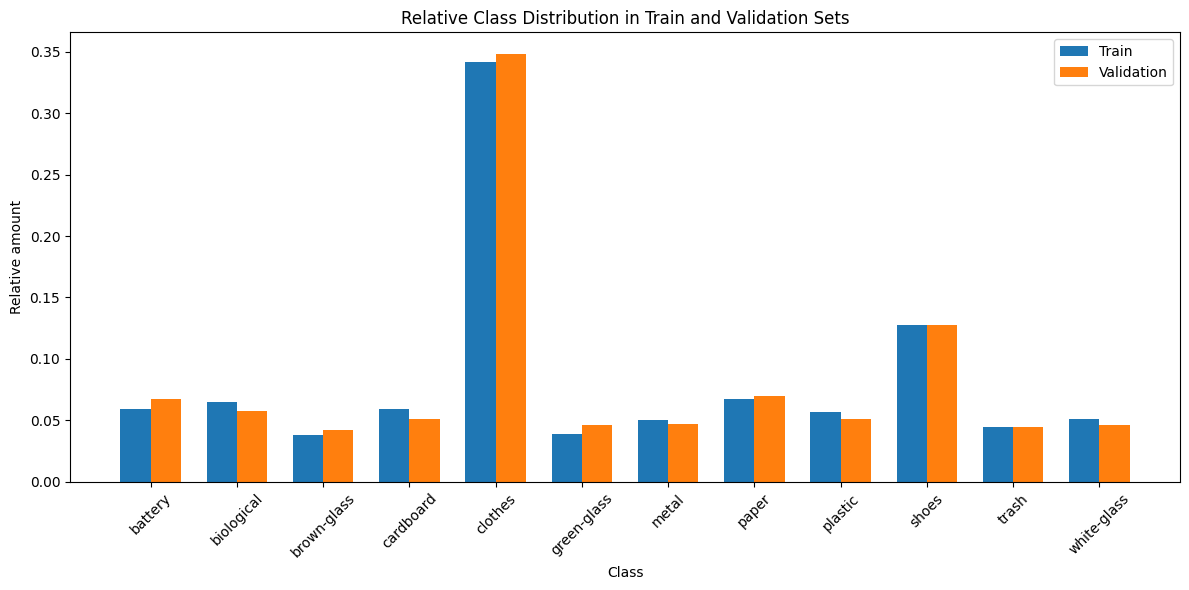

In [126]:
def show_distribution(subset, set_name):
    print("Distuction of", set_name, ": ")
    class_sizes = [0] * len(classes_names)
    for img, label in subset:
        class_sizes[label] += 1

    for idx in range(len(classes_names)):
        percent = 100 * class_sizes[idx] / len(subset)
        print(f"Class '{classes_names[idx]}': {class_sizes[idx]} images ({percent:.2f}%)")

def get_class_counts(subset):
    class_sizes = [0] * len(classes_names)
    for img, label in subset:
        class_sizes[label] += 1
    return class_sizes

def plot_class_distribution(train_dataset, test_dataset):
    num_classes = len(classes_names)
    train_counts = get_class_counts(train_dataset)
    val_counts = get_class_counts(test_dataset)

    # Convert counts to relative frequencies
    train_total = sum(train_counts)
    val_total = sum(val_counts)
    train_rel = [count / train_total for count in train_counts]
    val_rel = [count / val_total for count in val_counts]

    x = range(num_classes)
    width = 0.35  # width of the bars

    plt.figure(figsize=(12, 6))
    plt.bar(x, train_rel, width=width, label='Train')
    plt.bar([i + width for i in x], val_rel, width=width, label='Validation')
    plt.xticks([i + width/2 for i in x], classes_names, rotation=45)
    plt.xlabel('Class')
    plt.ylabel('Relative amount')
    plt.title('Relative Class Distribution in Train and Validation Sets')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_dataset=train_dataset, test_dataset = test_dataset)

### TODO 4:
Ensure that no single category accounts for more than 15% of the samples in the training set. If necessary, downsample the dominant classes. Then, visualize the new class distribution in the training set using a bar plot.



Class counts in Train Dataset BEFORE Downsampling:
battery: 736
biological: 806
brown-glass: 476
cardboard: 732
clothes: 4244
green-glass: 486
metal: 623
paper: 833
plastic: 706
shoes: 1581
trash: 558
white-glass: 631

Class counts in Train Dataset BEFORE Downsampling:
battery: 736
biological: 806
brown-glass: 476
cardboard: 732
clothes: 1861
green-glass: 486
metal: 623
paper: 833
plastic: 706
shoes: 1581
trash: 558
white-glass: 631


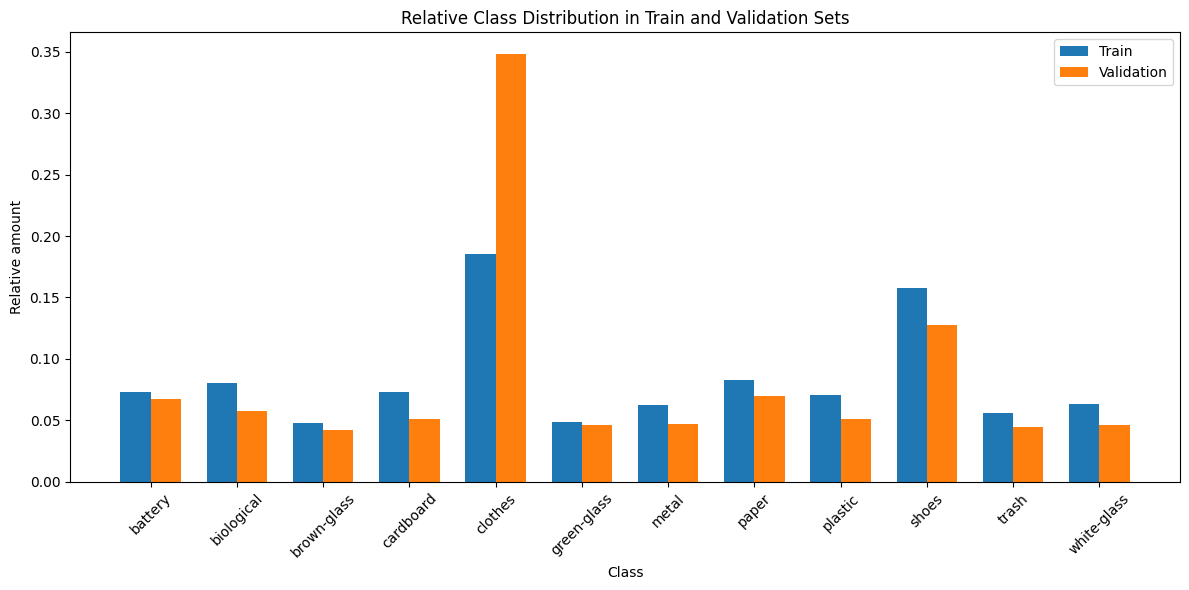

In [ ]:
import random
def print_class_counts(subset, dataset, classes_names, title=""):
    counts = [0] * len(classes_names)
    for idx in subset.indices:
        label = dataset.samples[idx][1]
        counts[label] += 1
    print(f"\nClass counts in {title}:")
    for i, name in enumerate(classes_names):
        print(f"{name}: {counts[i]}")

def downsample_images(dataset, classes_names):
    global train_dataset

    clothes_class_idx = classes_names.index("clothes")

    # Get indices (from the original 'dataset') that are 'clothes' in the current train_dataset
    original_clothes_indices_in_train = [idx for idx in train_dataset.indices
                                        if dataset.samples[idx][1] == clothes_class_idx]

    # Calculate the maximum allowed number of 'clothes' samples
    # It's 15% of the total samples in the *original* train_dataset size
    # Let's assume the initial train_dataset size is what you want 0.8 * len(dataset)
    initial_train_size = int(0.8 * len(dataset))
    max_clothes = int(0.15 * initial_train_size)

    # If the number of clothes samples exceeds the maximum, downsample
    if len(original_clothes_indices_in_train) > max_clothes:
        random.seed(42)
        selected_clothes_indices = random.sample(original_clothes_indices_in_train, max_clothes)
    else:
        selected_clothes_indices = original_clothes_indices_in_train

    # Get indices (from the original 'dataset') that are NOT 'clothes' in the current train_dataset
    original_other_indices_in_train = [idx for idx in train_dataset.indices
                                        if dataset.samples[idx][1] != clothes_class_idx]

    # Combine the selected clothes indices and all other indices
    final_indices_for_new_train_dataset = original_other_indices_in_train + selected_clothes_indices
    train_dataset = Subset(dataset, final_indices_for_new_train_dataset)

downsample_images()
plot_class_distribution(train_dataset=train_dataset, test_dataset=test_dataset)

## Implementation of Regularization Layers

Implement two regularization layers from scratch:
1. `BatchNorm2d`
2. `LayerNorm`

Make sure that all trainable parameters (such as scale and shift) are properly registered as part of the computational graph, so they are optimized during training.


### TODO 5:
Implement the BatchNorm2d layer from scratch using only basic PyTorch components (such as `nn.Module` and tensor operations), without relying on `nn.BatchNorm2d`.


In [130]:
import torch
import torch.nn as nn

class MyBatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super().__init__()
        self.num_features = num_features  # Number of feature channels (C in NCHW)
        self.eps = eps  # Small value to avoid division by zero when normalizing
        self.momentum = momentum  # Controls how quickly running stats are updated

        # Learnable scale (gamma) and shift (beta) parameters, one per channel.
        # These allow the network to undo normalization if needed, preserving representational power.
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

        # Running mean and variance are used during inference (model.eval()).
        # They accumulate a moving average of the mean/variance seen during training.
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))

    def forward(self, x):
        # x shape: (N, C, H, W) - batch, channels, height, width

        if self.training:
            # During training, compute mean and variance for each channel over the batch and spatial dims.
            # This normalizes each feature map (channel) so that its output has mean 0 and variance 1.
            mean = x.mean(dim=(0, 2, 3), keepdim=True)  # Shape: (1, C, 1, 1)
            var = x.var(dim=(0, 2, 3), unbiased=False, keepdim=True)  # Shape: (1, C, 1, 1)

            # Update running statistics for use during inference.
            # This helps the model make consistent predictions on unseen data (test/production).
            # Detach is used so that these updates are not part of the gradient computation.
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean.view(-1).detach()
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var.view(-1).detach()
        else:
            # During inference, use the running mean/var instead of batch statistics.
            # This ensures deterministic output and avoids dependence on batch size.
            mean = self.running_mean.view(1, -1, 1, 1)
            var = self.running_var.view(1, -1, 1, 1)

        # Normalize: subtract mean and divide by stddev (add eps for stability).
        # This reduces internal covariate shift, making training faster and more stable.
        x_hat = (x - mean) / torch.sqrt(var + self.eps)

        # Scale and shift: allow the network to learn optimal mean/variance for each channel.
        # This step ensures the transformation can represent the identity function if needed.
        out = self.gamma.view(1, -1, 1, 1) * x_hat + self.beta.view(1, -1, 1, 1)

        # The output is normalized, but can be rescaled and shifted as needed for learning.
        return out

### TODO 6:
Implement the LayerNorm layer from scratch using only basic PyTorch components (such as `nn.Module` and tensor operations), without relying on `nn.LayerNorm`.


In [131]:
import torch
import torch.nn as nn

class MyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        if isinstance(normalized_shape, int):
            normalized_shape = (normalized_shape,)
        self.normalized_shape = tuple(normalized_shape)
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(1, *self.normalized_shape, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, *self.normalized_shape, 1, 1))

    def forward(self, x):
        mean = x.mean(dim=(2, 3), keepdim=True)
        var = x.var(dim=(2, 3), keepdim=True, unbiased=False)
        x_hat = (x - mean) / torch.sqrt(var + self.eps)
        return self.gamma * x_hat + self.beta

## Traning 

### TODO 7:
Complete the `GarbageClassifier` neural network by designing and implementing an architecture of your choice.  
Make use of the provided `_block` and `_block_mp` building blocks as you see fit.  
Allow the regularization type (e.g., `BatchNorm2d` or `LayerNorm`) to be specified from outside the class, so you can later compare the results between the two types of regularization.


In [132]:
class GarbageClassifier(nn.Module):
    def __init__(self, num_classes, norm_layer):
        super(GarbageClassifier, self).__init__()

        self.features = nn.Sequential(
            self._block_mp(3, 96, kernel_size=11, stride=4, padding=0, norm_layer=norm_layer),
            self._block_mp(96, 256, kernel_size=5, stride=1, padding=2, norm_layer=norm_layer),
            self._block(256, 384, kernel_size=3, stride=1, padding=1, norm_layer=norm_layer),
            self._block(384, 384, kernel_size=3, stride=1, padding=1, norm_layer=norm_layer),
            self._block_mp(384, 256, kernel_size=3, stride=1, padding=1, norm_layer=norm_layer),
        )   
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

       
    def _block_mp(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, norm_layer=None, kernel_size_mp=2):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            norm_layer(out_channels),
            nn.MaxPool2d(kernel_size=kernel_size_mp),
            nn.ReLU(inplace=True)
        )

    def _block(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, norm_layer=None):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            norm_layer(out_channels),
            nn.ReLU(inplace=True)
        )
    

    def forward(self, x):
        # Forward pass through the feature extractor given self.features and self.classifier
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

### TODO 8:
Prepare all components needed for training:
1. Build your neural network with one type of regularization.
2. Create DataLoaders for the training (and optionally validation) sets.
3. Define the loss criterion.
4. Define the optimizer and assign it the trainable parameters of your model.
5. Print a summary of your network architecture.


In [133]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

lr = 0.0001
batch_size = 128
epoches = 10

loss_fn = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device:  cuda


### TODO 9:
Write a training loop to train your network for 10 epochs using the training set.
- Track and print the training loss for each epoch.
- After each epoch, compute and store both the loss and accuracy on the test set.
- After training, plot both the training and test losses on the same graph to visualize the learning process.
- Your model should achieve at least 75% accuracy on the test set.
- Remember to set your model to training mode (`model.train()`) during training, and to evaluation mode (`model.eval()`) when computing metrics on the test set.


In [134]:
def train_model(model, train_loader, test_loader, loss_fn, optimizer, device, epoches, classes_names):
    for epoch in range(epoches):
        model.train()  # Set the model to training mode
        running_loss = 0.0  # Track the loss for each epoch

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epoches}"):
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            optimizer.zero_grad()  # Zero the gradient buffers
            outputs = model(images)  # Forward pass
            loss = loss_fn(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update model weights

            running_loss += loss.item()  # Accumulate loss

        # Print loss for the epoch
        print(f"Epoch [{epoch+1}/{epoches}], Loss: {running_loss/len(train_loader):.4f}")


def test_model(model, test_loader, device, classes_names):
    model.eval()

    class_correct = [0 for _ in range(len(classes_names))]
    class_total = [0 for _ in range(len(classes_names))]

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            # Compare predictions to true labels
            for i in range(len(labels)):
                label = labels[i].item()
                pred = predicted[i].item()
                if label == pred:
                    class_correct[label] += 1
                class_total[label] += 1


    print("Per-class accuracy:")
    for i, class_name in enumerate(classes_names):
        if class_total[i] > 0:
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f"Class {class_name}: {accuracy:.2f}%")
        else:
            print(f"Class {class_name}: No samples in test set.")

In [135]:
modelBatchNorm = GarbageClassifier(num_classes=len(classes_names), norm_layer=MyBatchNorm2d)
modelBatchNorm = modelBatchNorm.to(device)
optimizerBatchNorm = torch.optim.Adam(modelBatchNorm.parameters(), lr=lr)

train_model(modelBatchNorm, train_loader, test_loader, loss_fn, optimizerBatchNorm, device, epoches, classes_names)
test_model(modelBatchNorm, test_loader, device, classes_names)

Epoch 1/10: 100%|██████████| 79/79 [00:28<00:00,  2.75it/s]


Epoch [1/10], Loss: 1.6446


Epoch 2/10: 100%|██████████| 79/79 [00:26<00:00,  2.93it/s]


Epoch [2/10], Loss: 1.2058


Epoch 3/10: 100%|██████████| 79/79 [00:36<00:00,  2.16it/s]


Epoch [3/10], Loss: 1.0333


Epoch 4/10: 100%|██████████| 79/79 [00:41<00:00,  1.92it/s]


Epoch [4/10], Loss: 0.9010


Epoch 5/10: 100%|██████████| 79/79 [00:37<00:00,  2.09it/s]


Epoch [5/10], Loss: 0.7518


Epoch 6/10: 100%|██████████| 79/79 [00:41<00:00,  1.91it/s]


Epoch [6/10], Loss: 0.6662


Epoch 7/10: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch [7/10], Loss: 0.5681


Epoch 8/10: 100%|██████████| 79/79 [00:50<00:00,  1.57it/s]


Epoch [8/10], Loss: 0.4487


Epoch 9/10: 100%|██████████| 79/79 [02:50<00:00,  2.15s/it]


Epoch [9/10], Loss: 0.3986


Epoch 10/10: 100%|██████████| 79/79 [00:53<00:00,  1.47it/s]


Epoch [10/10], Loss: 0.3486
Per-class accuracy:
Class battery: 67.94%
Class biological: 87.71%
Class brown-glass: 61.83%
Class cardboard: 54.72%
Class clothes: 85.66%
Class green-glass: 78.32%
Class metal: 28.08%
Class paper: 70.51%
Class plastic: 69.81%
Class shoes: 28.28%
Class trash: 58.27%
Class white-glass: 9.03%


In [136]:
#test_model(modelBatchNorm, test_loader, device, classes_names)

### TODO 10:
Compute and report the accuracy of your trained model on the test set for each individual category (class).

For example:
* Class battery: 80%
* Class biological: 71%
* Class brown-glass: 70%
* Class cardboard: 85%
* Class clothes: 92%
* Class green-glass: 88%
* Class metal: 43%
* Class paper: 54%
* Class plastic: 39%
* Class shoes: 71%
* Class trash: 68%
* Class white-glass: 55%


### Repeat TODOs 8,9 and 10 with the other type of regularization

Repeat the previous steps for preparing your model, DataLoaders, optimizer, and training loop, but this time using the alternative regularization layer. After training, compare the performance between the two regularization types.


In [137]:
modelLayerNorm = GarbageClassifier(num_classes=len(classes_names), norm_layer=MyLayerNorm)
modelLayerNorm = modelLayerNorm.to(device) 
optimizerLayerNorm = torch.optim.Adam(modelLayerNorm.parameters(), lr=lr)

train_model(modelLayerNorm, train_loader, test_loader, loss_fn, optimizerLayerNorm, device, epoches, classes_names)
test_model(modelLayerNorm, test_loader, device, classes_names)

Epoch 1/10:  80%|███████▉  | 63/79 [02:10<00:33,  2.07s/it]


KeyboardInterrupt: 

### Final Task: Summary and Analysis

Write a summary of your work and the results you obtained. In 3–4 paragraphs, discuss your approach, key findings, and any challenges you encountered. Compare the performance of the two different regularization techniques you implemented, and suggest possible reasons for any differences you observed. Reflect on what you learned and what you might try differently in future experiments.


Good luck!